# ResNet50 Analysis

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from keras.datasets import cifar100, cifar10
from keras.utils import np_utils
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize

In [2]:
def preprocess_data(num_classes):

    if num_classes == 100:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    else :
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        
    x_train = preprocess_input(x_train)
    x_test = preprocess_input(x_test)
   
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
       
    print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
    return (x_train, y_train), (x_test, y_test) 

In [9]:
def fit_model(num_classes, x_train, y_train, x_test, y_test):
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layer in resnet_model.layers:
      if isinstance(layer, BatchNormalization):
        layer.trainable = True
      else:
        layer.trainable = False
    
    model = Sequential()
    model.add(UpSampling2D(size=(7,7)))
    model.add(resnet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.25))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy', 'top_k_categorical_accuracy'])

    datagen = ImageDataGenerator(rotation_range=8,
                             shear_range=0.2, 
                             zoom_range=0.2,
                             channel_shift_range=0.05, 
                             horizontal_flip=True)
    datagen.fit(x_train)

    t=time.time()
    nb_epochs = 10
    batch_size = 64
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  epochs=nb_epochs,
                                  validation_data=(x_test, y_test))
    print('Training time: %s' % (time.time()-1))
    model.save('ResNet50_cifar'+str(num_classes)+'.h5')
    return history, model

In [5]:
def summarize_diagnostics(num_classes, history):
    cifar = 'CIFAR'+str(num_classes)
    plt.subplots_adjust(hspace=0.7)

    # plot loss
    plt.subplot(211)
    plt.title(cifar + ' Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    
    # plot accuracy
    plt.subplot(212)
    plt.title(cifar + ' Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # save plot to file
    #filename = "ResNet50_Pretrained"
    #plt.savefig(filename + '_plot.png')

In [6]:
def predict(model, x_test, y_test):
    ypred = model.predict(x_test)

    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(y_test[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)

        total += 1
    
    print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
    print('Accuracy:', round(accurate/total*100, 3), '%')
    return ypred

### Run with CIFAR100

Train: X=(50000, 32, 32, 3), y=(50000, 100)
Test: X=(10000, 32, 32, 3), y=(10000, 100)
Epoch 1/10
781/781 [==============================] - 432s 553ms/step - loss: 1.9476 - accuracy: 0.4963 - top_k_categorical_accuracy: 0.7839 - val_loss: 1.0981 - val_accuracy: 0.6741 - val_top_k_categorical_accuracy: 0.9274
Epoch 2/10
781/781 [==============================] - 433s 555ms/step - loss: 1.1526 - accuracy: 0.6668 - top_k_categorical_accuracy: 0.9185 - val_loss: 0.9044 - val_accuracy: 0.7267 - val_top_k_categorical_accuracy: 0.9468
Epoch 3/10
781/781 [==============================] - 432s 553ms/step - loss: 0.9811 - accuracy: 0.7093 - top_k_categorical_accuracy: 0.9373 - val_loss: 0.8292 - val_accuracy: 0.7472 - val_top_k_categorical_accuracy: 0.9527
Epoch 4/10
781/781 [==============================] - 432s 553ms/step - loss: 0.8917 - accuracy: 0.7330 - top_k_categorical_accuracy: 0.9475 - val_loss: 0.8147 - val_accuracy: 0.7540 - val_top_k_categorical_accuracy: 0.9545
Epoch 5/10
781/78

array([[2.4157821e-08, 4.3479801e-08, 5.2362349e-04, ..., 5.9743780e-07,
        3.6713718e-05, 2.9057082e-08],
       [2.5007052e-06, 3.1678650e-05, 2.3347947e-03, ..., 1.3161313e-03,
        1.9023426e-05, 2.0790327e-05],
       [2.9034788e-09, 6.7079600e-07, 1.3370175e-06, ..., 2.0333460e-05,
        8.1443162e-08, 5.0286695e-07],
       ...,
       [7.1658279e-09, 3.1905562e-10, 2.7445584e-09, ..., 2.7302494e-11,
        3.5359038e-10, 1.2094012e-10],
       [2.9352704e-14, 2.5472238e-09, 3.6040836e-12, ..., 5.4275802e-08,
        2.2912675e-11, 7.5217571e-10],
       [2.8077902e-05, 2.6196502e-03, 6.3582029e-06, ..., 1.5611820e-04,
        4.3276673e-06, 3.7958940e-05]], dtype=float32)

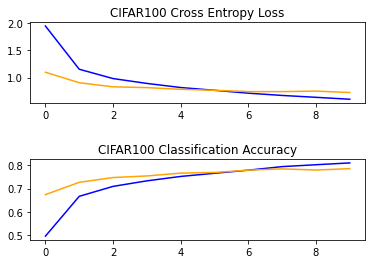

In [10]:
num_classes = 100
(x_train, y_train), (x_test, y_test) = preprocess_data(num_classes)
history, model = fit_model(num_classes, x_train, y_train,x_test, y_test)
print('\n\n')
summarize_diagnostics(num_classes, history)
print('\n')
pred = predict(model, x_test, y_test)

### Run with CIFAR10

170500096/170498071 [==============================] - 2s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)
Epoch 1/10
781/781 [==============================] - 428s 548ms/step - loss: 0.5939 - accuracy: 0.7961 - top_k_categorical_accuracy: 0.9853 - val_loss: 0.3315 - val_accuracy: 0.8863 - val_top_k_categorical_accuracy: 0.9979
Epoch 2/10
781/781 [==============================] - 432s 553ms/step - loss: 0.3308 - accuracy: 0.8874 - top_k_categorical_accuracy: 0.9971 - val_loss: 0.2282 - val_accuracy: 0.9188 - val_top_k_categorical_accuracy: 0.9994
Epoch 3/10
781/781 [==============================] - 431s 552ms/step - loss: 0.2679 - accuracy: 0.9079 - top_k_categorical_accuracy: 0.9981 - val_loss: 0.2129 - val_accuracy: 0.9253 - val_top_k_categorical_accuracy: 0.9992
Epoch 4/10
781/781 [==============================] - 432s 553ms/step - loss: 0.2349 - accuracy: 0.9192 - top_k_categorical_accuracy: 0.9984 - val_loss: 0.1817 - val_accuracy: 

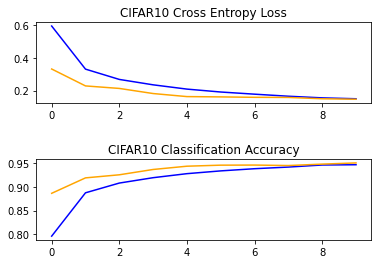

In [11]:
num_classes = 10
(x_train, y_train), (x_test, y_test) = preprocess_data(num_classes)
history, model = fit_model(num_classes, x_train, y_train,x_test, y_test)
print('\n\n')
summarize_diagnostics(num_classes, history)
print('\n')
pred = predict(model, x_test, y_test)